In [1]:
import os
import sys

os.getcwd()
os.chdir('/home/thabib/study_behavior_analysis/')
sys.path.append('/home/thabib/study_behavior_analysis/src/SidBERT')

In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from utils import settings
from embeddings_generator import load_embeddings
from src.reducers.pca import PCAReducer
from src.clusterers.kmeans import KMEANS_CLUSTERER
from src.clusterers.dbscan import DBSCAN_CLUSTERER
from src.clusterers.cluster_utils import get_kdist_plot

project_root = settings.get_project_root()

2022-03-28 13:47:58.359397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 13:47:58.359434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
classes_to_cluster = list(np.arange(10).astype('str')) # ['1','2','4','8','9']
n_samples = 5000

layer = 7 # 'pooler_output' # 2048 entries per sample for classification head, 
                        # for 'pooler_output' it is 768
original_only = True

# File name arguments for saving to disk
file_args = {
    'layer': layer,
    'classes': classes_to_cluster,
    'n_samples': n_samples,
    'original_only': original_only
}

In [5]:
dir_name = 'Layer{}_Classes{}_SamplesPerRootClass{}_OriginalOnly{}'.format(layer,
                                                                           ''.join(classes_to_cluster),
                                                                           n_samples,
                                                                           original_only)
data_filename = 'df_book_ddc'

df_data = pd.read_hdf(os.path.join(project_root, 'src', 'data', 'SidBERT_data', 'pca_embeddings', 
                                   dir_name, data_filename+'.hdf5'), mode='r', key=data_filename)

real_labels = list(df_data['root_class'])
df_data

,index,Title,DDC,root_class
0,1325,"Artificial neural nets and genetic algorithms,...",0063,0
1,1680,Byte guide to OpenDoc,0053,0
2,1987,"From natural to artificial neural computation,...",0063,0
3,3154,"Understanding neural networks and fuzzy logic,...",0063,0
4,6184,"14th international conference, Chicago, Illino...",003,0
...,...,...,...,...
49995,599442,Enzyklopädie deutscher Geschichte / hrsg. von ...,943,9
49996,602514,Festschrift zur 150-Jahrfeier der Frankfurter ...,910,9
49997,603071,Griechische Städteanlagen : Untersuchungen zur...,938,9
49998,603176,Die Befreiung des Prometheus : ein Fund aus Pe...,9301,9


In [7]:
# Load PCA embeddings with given values of #components, variance retention and used scaler
pca_comp = 240
pca_var = 85
pca_scaler = 'StandardScaler'
pca_filename = 'Comp{}_Var{}_Scaler{}'.format(pca_comp, pca_var, pca_scaler)

with np.load(os.path.join(project_root, 'src', 'data', 'SidBERT_data', 'pca_embeddings', dir_name, 
                          pca_filename+'.npz'), allow_pickle=True) as dt:
    pca_results_ = dict(dt)

reduced_embeddings = pca_results_['reduced_emb']

reduced_embeddings.shape

(50000, 240)

# k-Means

In [22]:
# Load pre-saved kMeans results from disk

kmeans_hyperparams = {
    'n_clusters_range': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'init_range': ['k-means++', 'random'],
    'max_iter_range': [500]
    }

kmeans_results_ = []
kmeans_results_idx = []

kmeans_dir_name = 'Layer{}_Classes{}_SamplesPerRootClass{}_OriginalOnly{}_PCAComp{}_PCAVar{}_PCAScaler{}'.format(
    layer, ''.join(classes_to_cluster), n_samples, original_only, pca_comp, pca_var, pca_scaler)


for init in kmeans_hyperparams['init_range']:
    for cl in kmeans_hyperparams['n_clusters_range']:
        for it in kmeans_hyperparams['max_iter_range']:
            file_name = 'Clusters{}_Init{}_Iter{}'.format(cl, init, it)
            with np.load(os.path.join(project_root, 'src', 'data', 'SidBERT_data', 'kmeans', kmeans_dir_name, 
                                      file_name+'.npz'), allow_pickle=True) as dt:
                results_ = dict(dt)
            kmeans_results_idx.append(file_name)
            kmeans_results_.append(results_)

kmeans_results_ = np.array(kmeans_results_, dtype=object)
kmeans_results_idx = np.array(kmeans_results_idx, dtype=object)

kmeans_results_.shape

(22,)

In [47]:
d = float(kmeans_results_[0]['db_score'])
d

9.731252296535231

In [49]:
int(kmeans_results_[0]['n_iter_'])

54

In [23]:
kmeans_results_idx

array(['Clusters5_Initk-means++_Iter500',
       'Clusters6_Initk-means++_Iter500',
       'Clusters7_Initk-means++_Iter500',
       'Clusters8_Initk-means++_Iter500',
       'Clusters9_Initk-means++_Iter500',
       'Clusters10_Initk-means++_Iter500',
       'Clusters11_Initk-means++_Iter500',
       'Clusters12_Initk-means++_Iter500',
       'Clusters13_Initk-means++_Iter500',
       'Clusters14_Initk-means++_Iter500',
       'Clusters15_Initk-means++_Iter500', 'Clusters5_Initrandom_Iter500',
       'Clusters6_Initrandom_Iter500', 'Clusters7_Initrandom_Iter500',
       'Clusters8_Initrandom_Iter500', 'Clusters9_Initrandom_Iter500',
       'Clusters10_Initrandom_Iter500', 'Clusters11_Initrandom_Iter500',
       'Clusters12_Initrandom_Iter500', 'Clusters13_Initrandom_Iter500',
       'Clusters14_Initrandom_Iter500', 'Clusters15_Initrandom_Iter500'],
      dtype=object)

#### Plot for maximum cluster size with number of clusters


In [26]:
random_init_cluster_sizes = {
    'max': [],
    'min': []
}
nonrandom_init_cluster_sizes = {
    'max': [],
    'min': []
}

for idx in range(len(kmeans_hyperparams['n_clusters_range'])):
    cluster_size_dict = dict(kmeans_results_[idx]['cluster_sizes'])
    nonrandom_init_cluster_sizes['max'].append(cluster_size_dict[next(reversed(cluster_size_dict.keys()))])
    nonrandom_init_cluster_sizes['min'].append(cluster_size_dict[next(iter(cluster_size_dict.keys()))])
    
    cluster_size_dict = dict(kmeans_results_[idx+len(kmeans_hyperparams['n_clusters_range'])]['cluster_sizes'])
    random_init_cluster_sizes['max'].append(cluster_size_dict[next(reversed(cluster_size_dict.keys()))])
    random_init_cluster_sizes['min'].append(cluster_size_dict[next(iter(cluster_size_dict.keys()))])

TypeError: iteration over a 0-d array

TypeError: plot got an unexpected keyword argument 'x'

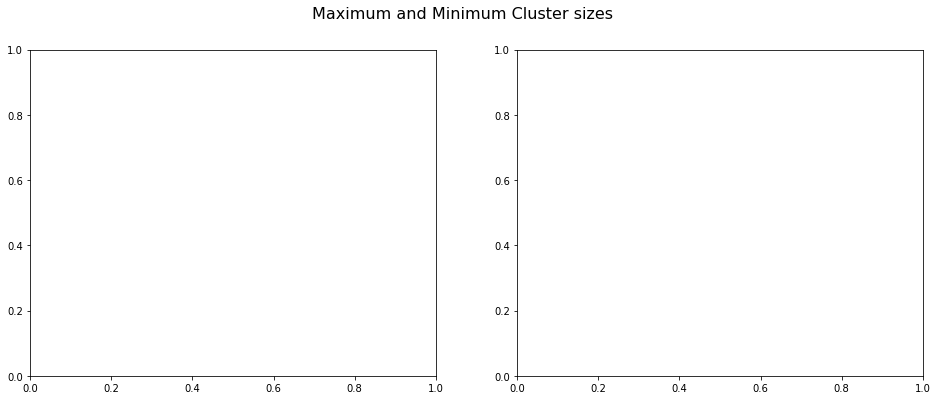

In [19]:



fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Maximum and Minimum Cluster sizes', fontsize=16)

axes[0].plot()
axes[0].title()

# DBSCAN

In [ ]:
# Load pre-saved DBSCAN results from disk

kmeans_hyperparams = {
    'n_clusters_range': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'init_range': ['k-means++', 'random'],
    'max_iter_range': [500]
    }

kmeans_results_ = []

pca_comp = 240
pca_var = 86
pca_scaler = 'StandardScaler'
kmeans_dir_name = 'Layer{}_Classes{}_SamplesPerRootClass{}_OriginalOnly{}_PCAComp{}_PCAVar{}_PCAScaler'.format(
    layer, ''.join(classes_to_visualize), n_samples, original_only, pca_comp, pca_var, pca_scaler)


for cl in kmeans_hyperparams['n_clusters_range']:
    for init in kmeans_hyperparams['init_range']:
        for it in kmeans_hyperparams['max_iter_range']:
            file_name = 'Cluster{}_Init{}_Iter{}'.format(cl, init, it)
            with np.load(os.path.join(project_root, 'src', 'data', 'SidBERT_data', 'kmeans', kmeans_dir_name, 
                                      file_name+'.npz'), allow_pickle=True) as dt:
                results_ = dict(dt)
            kmeans_results_.append(results_)